# Inpainting multi-variate timeseries data of Brain fMRI


- There are 424 parcels each with 842 timesteps(imagine a rectangle) in each file.

- In this code, I am taking 41 files and randomly sampling 128x128 data from the entire 424x842.

- I mask 128x20 from the right of the 128x128 which you'll see below in the code

- I train a GAN with a UNet structure that reconstructs the entire 128x128 image, including the masked bit.

- The intuition is that by giving any 128x108 data (128 parcels, each with 108 timesteps), you can forecast 20 more timesteps for each of the 128 parcels

- This is a new method for multivariate timeseries forecasting


## Import the libraries

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

# Set environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set random seed
random.seed(42)

## TimeSeriesPatchDataset

- The below class normalizes the data for Tanh, hence the data now lies between -1 and 1

- Randomly samples 10000 patches of size 128 x 128 from random files (out of 41)

- Masks the last 20 timesteps from the patch, hence 128x20 is emptied out


In [12]:
class TimeSeriesPatchDataset(Dataset):
    def __init__(self, file_list, num_patches_per_file, patch_size=128, mask_length=20):
        """
        file_list: List of file paths to CSV files.
        num_patches_per_file: Number of patches to sample from each file.
        """
        self.file_list = file_list
        self.num_files = len(file_list)
        self.num_patches_per_file = num_patches_per_file
        self.patch_size = patch_size
        self.mask_length = mask_length

        # Compute global min and max
        self.data_min, self.data_max = self.compute_global_min_max()

        # Precompute total patches and create an index mapping
        self.total_patches = self.num_files * self.num_patches_per_file
        self.index_mapping = []  # List of tuples (file_idx, patch_idx)

        for file_idx in range(self.num_files):
            for patch_idx in range(self.num_patches_per_file):
                self.index_mapping.append((file_idx, patch_idx))

    def compute_global_min_max(self):
        all_mins = []
        all_maxs = []
        for file_path in self.file_list:
            data = pd.read_csv(file_path).values
            data_tensor = torch.tensor(data, dtype=torch.float32)
            all_mins.append(data_tensor.min())
            all_maxs.append(data_tensor.max())
        data_min = min(all_mins)
        data_max = max(all_maxs)
        print(f"Global data min: {data_min}, max: {data_max}")
        return data_min, data_max

    def __len__(self):
        return self.total_patches

    def __getitem__(self, idx):
        # Get the file index and patch index from the mapping
        file_idx, _ = self.index_mapping[idx]
        file_path = self.file_list[file_idx]

        # Load the data from the file
        data = pd.read_csv(file_path).values
        data = torch.tensor(data, dtype=torch.float32)

        # Normalize the data
        data = (data - self.data_min) / (self.data_max - self.data_min + 1e-8)  # [0,1]
        data = data * 2 - 1  # [-1,1]

        parcels, timesteps = data.shape
        parcel_starts = parcels - self.patch_size
        time_starts = timesteps - self.patch_size

        if parcel_starts <= 0 or time_starts <= 0:
            raise ValueError("Patch size is larger than data dimensions.")

        # Randomize starting positions
        parcel_start = torch.randint(0, parcel_starts + 1, (1,)).item()
        time_start = torch.randint(0, time_starts + 1, (1,)).item()

        # Extract the patch
        patch = data[parcel_start:parcel_start+self.patch_size, time_start:time_start+self.patch_size]

        # Create mask: 1 for unmasked, 0 for masked
        mask = torch.ones_like(patch)
        mask[:, -self.mask_length:] = 0  # Mask the last 'mask_length' timesteps

        # Apply mask to create input_patch
        input_patch = patch * mask

        # The target is the full patch
        target_patch = patch

        return input_patch, target_patch, mask

In [13]:
from torch.utils.data import DataLoader, Subset

# Get the list of all CSV files
data_dir = "./data/fMRI_timeseries"
data_list = [os.path.join(data_dir, i) for i in os.listdir(data_dir) if i.endswith(".csv")]
data_list = sorted(data_list)
print(f"Found {len(data_list)} files.")

# Define total patches and patches per file
total_patches = 10000  # Total number of patches you want in the dataset
num_patches_per_file = total_patches // len(data_list) + 1  # Ensure all files contribute

# Create the combined dataset
dataset = TimeSeriesPatchDataset(data_list, num_patches_per_file=num_patches_per_file, patch_size=128, mask_length=20)

data_min, data_max = dataset.compute_global_min_max()


Found 41 files.


Global data min: -5.898799896240234, max: 5.988500118255615
Global data min: -5.898799896240234, max: 5.988500118255615


In [14]:
# Split indices into training, validation, and test sets
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split = 0.8
val_split = 0.1
test_split = 0.1

train_end = int(train_split * dataset_size)
val_end = train_end + int(val_split * dataset_size)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

# Create Subsets for training, validation, and test
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 8003
Validation dataset size: 1000
Test dataset size: 1001


In [15]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
print(f"Train dataset: {len(train_dataset)} patches, {len(train_loader)} batches")
print(f"Val dataset: {len(val_dataset)} patches, {len(val_loader)} batches")
print(f"Test dataset: {len(test_dataset)} patches, {len(test_loader)} batches")

Train dataset: 8003 patches, 251 batches
Val dataset: 1000 patches, 32 batches
Test dataset: 1001 patches, 32 batches


tensor([[ 0.0575,  0.0741,  0.1073,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1497,  0.1686,  0.1894,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1204, -0.0956, -0.0518,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [ 0.1645,  0.1582,  0.1470,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0470, -0.0402, -0.0430,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1480,  0.1408,  0.1547,  ...,  0.0000,  0.0000,  0.0000]])


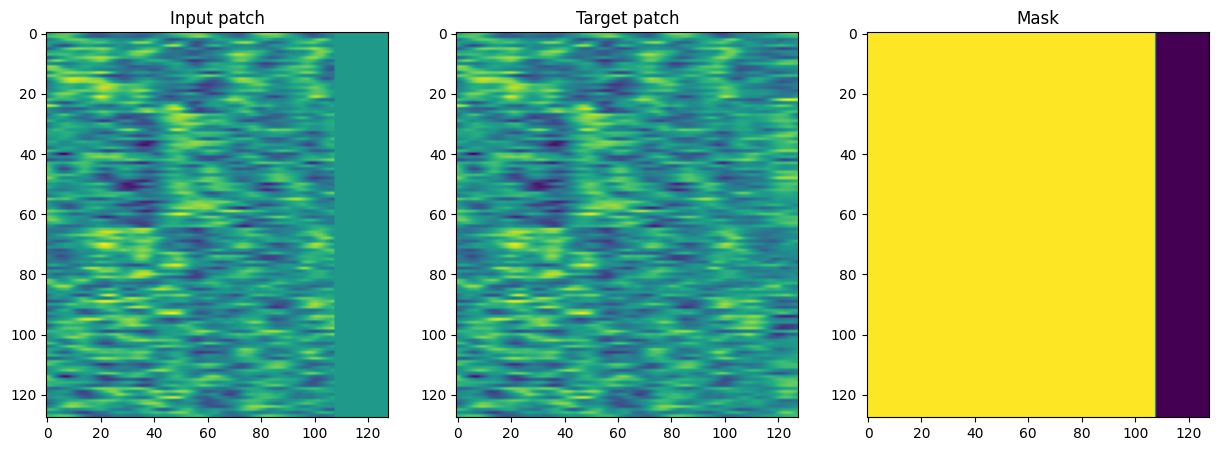

In [17]:
# Display the input patch and target patch in a plot
input_patch, target_patch, mask = train_dataset[0]
print(input_patch)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_patch, aspect="auto")
plt.title("Input patch")
plt.subplot(1, 3, 2)
plt.imshow(target_patch, aspect="auto")
plt.title("Target patch")
plt.subplot(1, 3, 3)
plt.imshow(mask, aspect="auto")
plt.title("Mask")
plt.show()

## The GAN architecture

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define encoder layers
        self.enc1 = nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.enc4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())

        # Define decoder layers with skip connections
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(128, 1, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Decoder with skip connections
        d4 = self.dec4(e4)
        d4 = torch.cat((d4, e3), dim=1)
        d3 = self.dec3(d4)
        d3 = torch.cat((d3, e2), dim=1)
        d2 = self.dec2(d3)
        d2 = torch.cat((d2, e1), dim=1)
        d1 = self.dec1(d2)
        return d1



# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),   # [batch, 64, 64, 64]
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), # [batch, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),# [batch, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),# [batch, 512, 8, 8]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 2, 1),  # [batch, 1, 4, 4]
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1 * 4 * 4, 1)  # Removed Sigmoid activation

    def forward(self, x):
        x = self.model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x  # Output logits

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers
# Increase generator learning rate
generator_lr = 2e-4
# Decrease discriminator learning rate
discriminator_lr = 1e-5

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=generator_lr, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(0.5, 0.999))

# Learning rate schedulers
generator_scheduler = torch.optim.lr_scheduler.StepLR(generator_optimizer, step_size=10, gamma=0.5)
discriminator_scheduler = torch.optim.lr_scheduler.StepLR(discriminator_optimizer, step_size=10, gamma=0.5)

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
reconstruction_loss = nn.MSELoss()

num_epochs = 50
lambda_recon = 500 # Weight for reconstruction loss

/tmp/ipykernel_644368/2662318847.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_best.pth'))


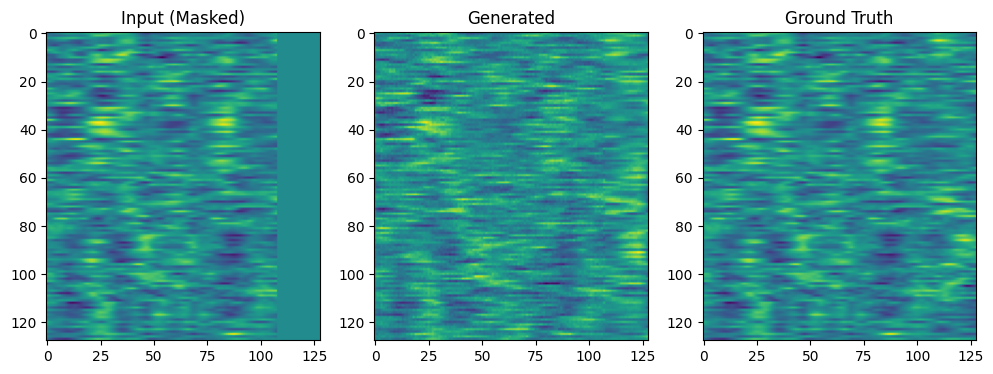

In [20]:
try:
    generator.load_state_dict(torch.load('generator_best.pth'))
except:
    print("No model found. Evaluating from scratch")
    
generator.eval()
with torch.no_grad():
    for input_patch, target_patch, mask in test_loader:
        input_patch = input_patch.unsqueeze(1).to(device)
        target_patch = target_patch.unsqueeze(1).to(device)
        mask = mask.unsqueeze(1).to(device)

        # Generate the inpainted patch
        gen_input = torch.cat([input_patch, mask], dim=1)
        generated_patch = generator(gen_input)

        # Reverse the normalization
        # Scale from [-1, 1] back to [0, 1]
        generated_patch = (generated_patch + 1) / 2
        target_patch = (target_patch + 1) / 2

        # Scale from [0, 1] back to original data range
        generated_patch = generated_patch * (data_max - data_min) + data_min
        target_patch = target_patch * (data_max - data_min) + data_min

        # Visualize results
        input_patch = input_patch.cpu().numpy()
        target_patch = target_patch.cpu().numpy()
        generated_patch = generated_patch.cpu().numpy()

        # Plot example
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_patch[0, 0], aspect='auto', cmap='viridis')
        plt.title("Input (Masked)")
        plt.subplot(1, 3, 2)
        plt.imshow(generated_patch[0, 0], aspect='auto', cmap='viridis')
        plt.title("Generated")
        plt.subplot(1, 3, 3)
        plt.imshow(target_patch[0, 0], aspect='auto', cmap='viridis')
        plt.title("Ground Truth")
        plt.show()
        break  # Only process one batch for demonstration

## Run this training loop only to train a new model, make sure it doesnt overwrite the saved model

In [ ]:
best_val_g_loss = float('inf')

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    g_loss_total = 0
    d_loss_total = 0
    g_adv_loss_total = 0
    recon_loss_total = 0

    for input_patch, target_patch, mask in tqdm(train_loader):
        # Prepare inputs
        input_patch = input_patch.to(device)       # [B, 128, 128]
        target_patch = target_patch.to(device)     # [B, 128, 128]
        mask = mask.to(device)                     # [B, 128, 128]

        # Expand mask if necessary
        if mask.shape[1] == 1:
            mask = mask.repeat(1, 128, 1)  # [B, 128, 128]

        # Generator input
        gen_input = torch.cat([input_patch, mask], dim=1)  # [B, 256, 128]

        # Update Discriminator
        discriminator_optimizer.zero_grad()
        real_labels = torch.full((input_patch.size(0),), 0.9, device=device)
        fake_labels = torch.full((input_patch.size(0),), 0.1, device=device)

        # Real data
        real_input = torch.cat([target_patch, mask], dim=1)  # [B, 256, 128]
        real_output = discriminator(real_input)               # [B]
        d_real_loss = adversarial_loss(real_output, real_labels)

        # Fake data
        generated_patch = generator(gen_input)                # [B, 128, 128]
        fake_input = torch.cat([generated_patch.detach(), mask], dim=1)  # [B, 256, 128]
        fake_output = discriminator(fake_input)               # [B]
        d_fake_loss = adversarial_loss(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        discriminator_optimizer.step()
        d_loss_total += d_loss.item()

        # Update Generator
        generator_optimizer.zero_grad()
        fake_input_for_gen = torch.cat([generated_patch, mask], dim=1)  # [B, 256, 128]
        fake_output = discriminator(fake_input_for_gen)                 # [B]
        g_adv_loss = adversarial_loss(fake_output, real_labels)
        recon_loss = reconstruction_loss(generated_patch, target_patch)
        g_loss = g_adv_loss + lambda_recon * recon_loss
        g_loss.backward()
        generator_optimizer.step()
        g_adv_loss_total += g_adv_loss.item()
        recon_loss_total += recon_loss.item()

    # Step learning rate schedulers
    generator_scheduler.step()
    discriminator_scheduler.step()

    # Print epoch losses
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"D Loss: {d_loss_total/len(train_loader):.4f}  "
          f"G Adv Loss: {g_adv_loss_total/len(train_loader):.4f}  "
          f"Recon Loss: {recon_loss_total/len(train_loader):.4f}")

    # --- Validation Phase ---
    generator.eval()
    discriminator.eval()

    val_g_loss_total = 0
    val_d_loss_total = 0

    with torch.no_grad():
        for input_patch, target_patch, mask in val_loader:
            input_patch = input_patch.to(device)
            target_patch = target_patch.to(device)
            mask = mask.to(device)

            if mask.shape[1] == 1:
                mask = mask.repeat(1, 128, 1)

            real_labels = torch.ones(input_patch.size(0), device=device)
            fake_labels = torch.zeros(input_patch.size(0), device=device)

            # Real data
            real_input = torch.cat([target_patch, mask], dim=1)  # [B, 256, 128]
            real_output = discriminator(real_input)               # [B]
            d_real_loss = adversarial_loss(real_output, real_labels)

            # Fake data
            gen_input = torch.cat([input_patch, mask], dim=1)     # [B, 256, 128]
            generated_patch = generator(gen_input)                # [B, 128, 128]
            fake_input = torch.cat([generated_patch, mask], dim=1)  # [B, 256, 128]
            fake_output = discriminator(fake_input)               # [B]
            d_fake_loss = adversarial_loss(fake_output, fake_labels)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            val_d_loss_total += d_loss.item()

            # Generator loss
            fake_output_for_gen = discriminator(fake_input)       # [B]
            g_adv_loss = adversarial_loss(fake_output_for_gen, real_labels)
            recon_loss = reconstruction_loss(generated_patch, target_patch)
            g_loss = g_adv_loss + lambda_recon * recon_loss
            val_g_loss_total += g_loss.item()

    # Average validation losses
    avg_val_d_loss = val_d_loss_total / len(val_loader)
    avg_val_g_loss = val_g_loss_total / len(val_loader)

    # Print validation losses
    print(f"Validation D Loss: {avg_val_d_loss:.4f}  G Loss: {avg_val_g_loss:.4f}")

    # Save the model if validation loss improves
    if avg_val_g_loss < best_val_g_loss:
        best_val_g_loss = avg_val_g_loss
        torch.save(generator.state_dict(), 'generator_new_best.pth')
        torch.save(discriminator.state_dict(), 'discriminator_new_best.pth')
        print('Model saved with improved validation generator loss.')


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch [1/50]  D Loss: 0.6714  G Adv Loss: 0.7934  Recon Loss: 0.0306
Validation D Loss: 0.7898  G Loss: 5.5834
Model saved with improved validation generator loss.


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch [2/50]  D Loss: 0.6739  G Adv Loss: 0.7640  Recon Loss: 0.0242
Validation D Loss: 0.7222  G Loss: 5.0620
Model saved with improved validation generator loss.


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch [3/50]  D Loss: 0.6646  G Adv Loss: 0.7684  Recon Loss: 0.0229
Validation D Loss: 0.7094  G Loss: 4.8336
Model saved with improved validation generator loss.


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch [4/50]  D Loss: 0.6579  G Adv Loss: 0.7816  Recon Loss: 0.0225
Validation D Loss: 0.7307  G Loss: 4.7391
Model saved with improved validation generator loss.


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch [5/50]  D Loss: 0.6479  G Adv Loss: 0.8023  Recon Loss: 0.0225
Validation D Loss: 0.6867  G Loss: 4.5755
Model saved with improved validation generator loss.


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch [6/50]  D Loss: 0.6511  G Adv Loss: 0.7871  Recon Loss: 0.0225
Validation D Loss: 0.7488  G Loss: 4.8914


  0%|          | 0/251 [00:00<?, ?it/s]

## Model Inference

/tmp/ipykernel_644368/2662318847.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_best.pth'))


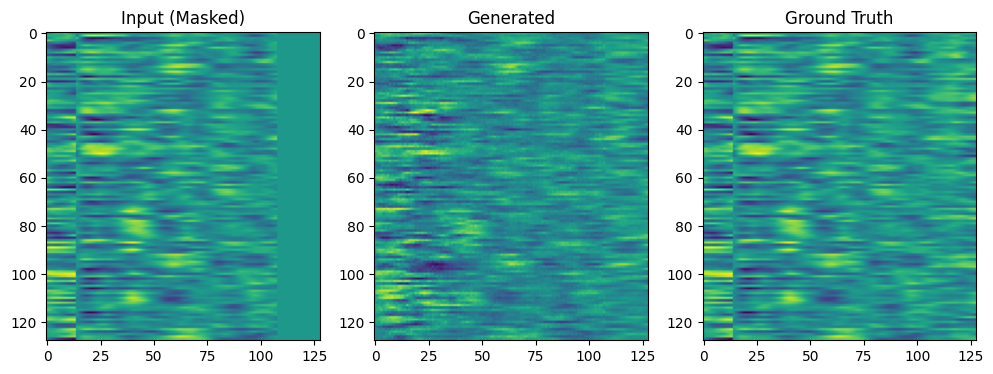

In [ ]:
try:
    generator.load_state_dict(torch.load('best_model_yet.pth'))
except:
    print("No model found. Evaluating from scratch")
    
generator.eval()
with torch.no_grad():
    for input_patch, target_patch, mask in test_loader:
        input_patch = input_patch.unsqueeze(1).to(device)
        target_patch = target_patch.unsqueeze(1).to(device)
        mask = mask.unsqueeze(1).to(device)

        # Generate the inpainted patch
        gen_input = torch.cat([input_patch, mask], dim=1)
        generated_patch = generator(gen_input)

        # Reverse the normalization
        # Scale from [-1, 1] back to [0, 1]
        generated_patch = (generated_patch + 1) / 2
        target_patch = (target_patch + 1) / 2

        # Scale from [0, 1] back to original data range
        generated_patch = generated_patch * (data_max - data_min) + data_min
        target_patch = target_patch * (data_max - data_min) + data_min

        # Visualize results
        input_patch = input_patch.cpu().numpy()
        target_patch = target_patch.cpu().numpy()
        generated_patch = generated_patch.cpu().numpy()

        # Plot example
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_patch[0, 0], aspect='auto', cmap='viridis')
        plt.title("Input (Masked)")
        plt.subplot(1, 3, 2)
        plt.imshow(generated_patch[0, 0], aspect='auto', cmap='viridis')
        plt.title("Generated")
        plt.subplot(1, 3, 3)
        plt.imshow(target_patch[0, 0], aspect='auto', cmap='viridis')
        plt.title("Ground Truth")
        plt.show()
        break  # Only process one batch for demonstration

In [ ]:
with torch.no_grad():
    input_patch, target_patch, mask = test_dataset[3] # Select a random test sample
    
    input_patch = input_patch.unsqueeze(0).unsqueeze(0).to(device) # [1, 1, 128, 128]
    target_patch = target_patch.unsqueeze(0).unsqueeze(0).to(device) # [1, 1, 128, 128]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device) # [1, 1, 128, 20]
    
    gen_input = torch.cat([input_patch, mask], dim=1)
    generated_patch = generator(gen_input)

    # Reverse normalization
    generated_patch = (generated_patch + 1) / 2
    target_patch = (target_patch + 1) / 2
    generated_patch = generated_patch * (data_max - data_min) + data_min
    target_patch = target_patch * (data_max - data_min) + data_min

    # Convert to numpy
    generated_patch = generated_patch.cpu().numpy()
    target_patch = target_patch.cpu().numpy()
    mask = mask.cpu().numpy()
    
for parcel_index in range(128):
    # Extract the time series for the selected parcel
    gen = generated_patch[0, 0, parcel_index, -20:]  # Shape: [timesteps]
    tar = target_patch[0, 0, parcel_index, :]     # Shape: [timesteps]
    # gen is target till 108 + the generated part
    gen = np.concatenate((tar[:-20], gen), axis=0)

    # print(f"Generated Shape: {gen.shape}")
    # print(f"Ground Truth Shape: {tar.shape}")
    
    r2 = r2_score(gen[-20:], tar[-20:])
    if r2 > 0.5: # print parcels that have a good r2 score
        print(parcel_index, r2)

1 0.6187266707420349
12 0.579572319984436
16 0.8656070828437805
21 0.5901194214820862
28 0.6593035459518433
29 0.8555678129196167
32 0.9040997624397278
37 0.6663472652435303
57 0.5221201181411743
62 0.5601494312286377
71 0.8536270260810852
73 0.581437885761261
74 0.739020824432373
77 0.8591029644012451
80 0.8960127234458923
81 0.8303076028823853
87 0.6697447299957275
96 0.5892901420593262
97 0.5048067569732666
98 0.8909037113189697
99 0.674530029296875
100 0.5802671313285828
101 0.8688098192214966
106 0.5871472954750061
119 0.9263549447059631
120 0.776794970035553
124 0.7499030232429504


Generated Shape: (128,)
Ground Truth Shape: (128,)


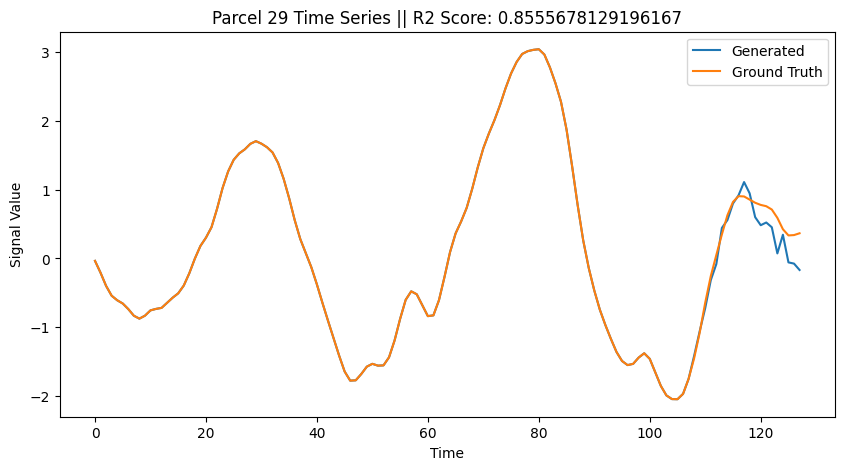

In [74]:
# Select a specific parcel (e.g., the first parcel)
parcel_index = 29 # Change as needed

# Extract the time series for the selected parcel
gen = generated_patch[0, 0, parcel_index, -20:]  # Shape: [timesteps]
tar = target_patch[0, 0, parcel_index, :]     # Shape: [timesteps]
# gen is target till 108 + the generated part
gen = np.concatenate((tar[:-20], gen), axis=0)

r2 = r2_score(gen[-20:], tar[-20:])

print(f"Generated Shape: {gen.shape}")
print(f"Ground Truth Shape: {tar.shape}")

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(gen, label="Generated")
plt.plot(tar, label="Ground Truth")
plt.legend()
plt.title(f"Parcel {parcel_index} Time Series || R2 Score: {r2}")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.show()